# Predicting Passage of US Constitutional Amendments #  

Ratified in 1789, the United States Constitution is the foundational document for the structure of government and law in the United States of America.  As the authors foresaw the necessity of updating the Constitution to meet the nation’s changing needs, they vested Congress and the states with joint power to append Constitutional amendments.  In the intervening 228 years, over 11,000 proposed amendments1 have been introduced by members of Congress, but only thirty-three have passed Congressional muster, and of those, only twenty-seven have been successfully ratified by the states and made into law.  Amendments which have passed range from the enormously impactful, such as abolishing slavery (13th) and granting women the right to vote (19th), to the somewhat mundane, such as delaying Congressional salary raises from taking effect until the following election (27th).  The last successful Constitutional amendment ratified was in 1992; with nearly 1000 failed proposed amendments from 1993-2014 alone, a study into which variables are predictors of amendment success is warranted.

# Import and merge data

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import pickle
import visuals as vs
import matplotlib.pyplot as plt
import random
import math

In [2]:
# amendment data retrieved on April 6, 2017 from:
# https://www.archives.gov/open/dataset-amendments.html

try:
    data = pd.read_csv('us-nara-amending-america-dataset-amend.csv')
    print('Amendment data has {} samples with {} features each'.format(*data.shape))
except:
    'Dataset not found.'

Amendment data has 11797 samples with 18 features each


In [3]:
# print header
display(list(data))
display(data.head())

['amendment',
 'identifier',
 'source_code',
 'source_citation',
 'source_index_number',
 'title_or_description_from_source',
 'date_approximation',
 'year',
 'month',
 'day',
 'congress',
 'congressional_session',
 'joint_resolution_chamber',
 'joint_resolution_number',
 'sponsor_name',
 'sponsor_state_or_territory',
 'committee_of_referral',
 'last_modified']

,amendment,identifier,source_code,source_citation,source_index_number,title_or_description_from_source,date_approximation,year,month,day,congress,congressional_session,joint_resolution_chamber,joint_resolution_number,sponsor_name,sponsor_state_or_territory,committee_of_referral,last_modified
0,10,us-nara-amending-america-000001,A,"Ames, Herman V. The Proposed Amendments to the...",1,Reservation of nondelegated powers,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00
1,14,us-nara-amending-america-000002,A,"Ames, Herman V. The Proposed Amendments to the...",2,Apportionment of Representatives,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00
2,NaN,us-nara-amending-america-000003,A,"Ames, Herman V. The Proposed Amendments to the...",3,Restriction on Federal control over election o...,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00
3,NaN,us-nara-amending-america-000004,A,"Ames, Herman V. The Proposed Amendments to the...",4,Restriction upon the levying of direct taxes,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00
4,NaN,us-nara-amending-america-000005,A,"Ames, Herman V. The Proposed Amendments to the...",5,Commercial monopolies prohibited,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00


Based on the header extract above, 'identifier', 'source_code', 'source_citation', 'source_index_number', and 'last_modified' are not relevant to this project as they are only references to the originating data source.  

'joint_resolution_number' is also unlikely to be relevant to any analysis and is likely strongly correlated to the date, so it does not add enough information value to justify remaining a feature.

These can be removed from the dataframe along with entries with no title.

In [4]:
# drop irrelevant features
data.drop(['identifier', 'source_code', 'source_citation', 'source_index_number', 
           'joint_resolution_number', 'last_modified'], axis = 1, inplace = True)

# rename long column names
data.rename(columns={'title_or_description_from_source':'title',
                    'sponsor_state_or_territory': 'sponsor_state'}, inplace=True)

# drop rows with no title
data.dropna(axis=0,subset=['title'],inplace=True)
# reindex
data.reset_index(drop=True, inplace=True)

In [5]:
# review missing data by calculating percentage NaNs in each column
print('Percentage Missing Data for Each Feature')
print(data.isnull().sum()/data.shape[0]*100)

Percentage Missing Data for Each Feature
amendment                   77.598779
title                        0.000000
date_approximation          94.378498
year                         0.042394
month                        5.748686
day                          5.748686
congress                     7.402069
congressional_session       79.582839
joint_resolution_chamber    16.652535
sponsor_name                 7.054434
sponsor_state                7.639478
committee_of_referral       66.915381
dtype: float64


'date_approximation' has the most missing values and appears to add no value to the data since year is populated for nearly all examples.  'congressional_session' is also missing for a majority of examples and should be removed since it adds little information to the analysis.  'committee_of_referral' has a large percentage of missing values, but it may be a significant feature, so it will be retained.

In [6]:
# drop irrelevant features
data.drop(['date_approximation', 'congressional_session'], axis = 1, inplace = True)

In [7]:
import yaml

# legislator data retrieved on April 6, 2017 from:
# https://github.com/unitedstates/congress-legislators

try:
    legis_data = yaml.safe_load(open('legislators-historical.yaml','r'))
    legis_data.extend(yaml.safe_load(open('legislators-current.yaml','r')))
except yaml.YAMLError as exc:
    print(exc)

In [8]:
# display example of legislator data entry
display(legis_data[-1])

{'bio': {'birthday': '1953-03-01', 'gender': 'M'},
 'id': {'bioguide': 'S001202',
  'cspan': 9278255,
  'fec': ['S8AL00308'],
  'govtrack': 412734,
  'lis': 'S392',
  'maplight': 2245,
  'wikidata': 'Q6705642',
  'wikipedia': 'Luther Strange'},
 'name': {'first': 'Luther',
  'last': 'Strange',
  'official_full': 'Luther Strange'},
 'terms': [{'address': 'G-12 Dirksen Senate Office Building Washington DC 20510',
   'class': 2,
   'end': '2021-01-03',
   'office': 'G-12 Dirksen Senate Office Building',
   'party': 'Republican',
   'phone': '202-224-4124',
   'start': '2017-02-09',
   'state': 'AL',
   'state_rank': 'junior',
   'type': 'sen'}]}

In [9]:
# create dataframe of legislator data indexed by name
legis_list = []
name_list = []

i = 0
while i < len(legis_data):
    # extract first term data entry
    entry = legis_data[i]['terms'][0]
    # extract last term end date
    entry['end'] = legis_data[i]['terms'][-1]['end']
    # concat first and last names for index
    name = legis_data[i]['name']['first']+' '+legis_data[i]['name']['last']
    
    legis_list.append(entry)
    name_list.append(name)
    
    i += 1

legis_df = pd.DataFrame(legis_list, name_list)
display(legis_df.head())

,address,caucus,class,contact_form,district,end,fax,office,party,party_affiliations,phone,rss_url,start,state,state_rank,type,url
Richard Bassett,NaN,NaN,2.0,NaN,NaN,1793-03-03,NaN,NaN,Anti-Administration,NaN,NaN,NaN,1789-03-04,DE,NaN,sen,NaN
Theodorick Bland,NaN,NaN,NaN,NaN,9.0,1791-03-03,NaN,NaN,NaN,NaN,NaN,NaN,1789-03-04,VA,NaN,rep,NaN
Aedanus Burke,NaN,NaN,NaN,NaN,2.0,1791-03-03,NaN,NaN,NaN,NaN,NaN,NaN,1789-03-04,SC,NaN,rep,NaN
Daniel Carroll,NaN,NaN,NaN,NaN,6.0,1791-03-03,NaN,NaN,NaN,NaN,NaN,NaN,1789-03-04,MD,NaN,rep,NaN
George Clymer,NaN,NaN,NaN,NaN,-1.0,1791-03-03,NaN,NaN,NaN,NaN,NaN,NaN,1789-03-04,PA,NaN,rep,NaN


In [10]:
# drop irrelevant features
legis_df.drop(['address', 'caucus', 'class', 'contact_form', 'fax', 'office', 
               'party_affiliations', 'phone', 'rss_url', 'state_rank', 
               'url'], axis = 1, inplace = True)

In [11]:
# truncate legislator data start/end to years only
legis_df['start'] = legis_df['start'].str[:4].astype(int)
legis_df['end'] = legis_df['end'].str[:4].astype(int)

# calculate legislator term length
legis_df['term'] = legis_df['end'] - legis_df['start']

display(legis_df.head())
display(legis_df.tail())

,district,end,party,start,state,type,term
Richard Bassett,NaN,1793,Anti-Administration,1789,DE,sen,4
Theodorick Bland,9.0,1791,NaN,1789,VA,rep,2
Aedanus Burke,2.0,1791,NaN,1789,SC,rep,2
Daniel Carroll,6.0,1791,NaN,1789,MD,rep,2
George Clymer,-1.0,1791,NaN,1789,PA,rep,2


,district,end,party,start,state,type,term
Thomas Garrett,5.0,2019,Republican,2017,VA,rep,2
Pramila Jayapal,7.0,2019,Democrat,2017,WA,rep,2
Mike Gallagher,8.0,2019,Republican,2017,WI,rep,2
Liz Cheney,0.0,2019,Republican,2017,WY,rep,2
Luther Strange,NaN,2021,Republican,2017,AL,sen,4


In [12]:
# function to find legislator entry by name and year
def find_leg(name, year, legis_df):
    firstname = np.NaN
    namesplit = name.split(', ') #split if last and first name are present
    lastname = namesplit[0]
    
    # if a first name is present, search by both names
    if len(namesplit) > 1:
        # split out first name only, ignoring any middle names/initials
        firstname = namesplit[1].split(' ')[0]
        # find legislator by search index for matching last & first name
        for entry in legis_df.itertuples():
            if lastname in entry.Index and firstname in entry.Index:
                return entry
            
    # only last name is known, narrow search by year
    else:
        for entry in legis_df.itertuples(): #faster than iterrows
            if lastname in entry.Index: #search index of names for matching last name
                if (year >= entry.start) and (year <= entry.end): #is proposal within the term start and end
                    return entry

In [13]:
# pair legislators to proposal data

# strip whitespace
data['sponsor_name'] = data['sponsor_name'].str.strip()

# iterate through each proposal to see if a legislator can be paired
for proposal in data.itertuples(): #faster than iterrows
    name = proposal.sponsor_name
    
    # if name is populated, find legislator data
    if pd.notnull(name) == True:
        year = proposal.year
        entry = find_leg(name, year, legis_df)
        
        # if legislator data was found, add it to the proposal df
        if pd.notnull(entry) == True:
            for label, value in entry._asdict().items():
                if pd.notnull(value) == True:
                    data.set_value(proposal.Index, 'legis_'+label, value)

# drop legis_end column since the data is redundant to legis_start + legis_term
data.drop('legis_end', axis = 1, inplace = True)

In [14]:
# review missing data by calculating percentage NaNs in each column
print('Percentage Missing Data for Each Feature')
print(data.isnull().sum()/data.shape[0]*100)

Percentage Missing Data for Each Feature
amendment                   77.598779
title                        0.000000
year                         0.042394
month                        5.748686
day                          5.748686
congress                     7.402069
joint_resolution_chamber    16.652535
sponsor_name                 7.054434
sponsor_state                7.639478
committee_of_referral       66.915381
legis_Index                 11.217568
legis_district              22.697982
legis_start                 11.217568
legis_state                 11.217568
legis_type                  11.217568
legis_term                  11.217568
legis_party                 11.624555
dtype: float64


95% of the 'sponsor_names' were paired to legislator data - pretty good!

In [15]:
# list all identified parties to maintain consistent naming on party divisions data
print(data['legis_party'].value_counts())

Republican                  5100
Democrat                    4967
Whig                          87
Federalist                    52
Jackson                       46
Ind. Republican-Democrat      37
Populist                      30
Farmer-Labor                  12
American                      12
Ind. Democrat                 11
Progressive                   10
Adams                          9
Socialist                      6
Independent                    5
Conservative                   5
Democratic Republican          5
National Greenbacker           4
Unionist                       4
Ind. Republican                3
Free Soil                      3
Unconditional Unionist         3
Pro-Administration             2
Conservative Republican        2
Prohibitionist                 2
Anti-Jacksonian                2
Union Labor                    1
Jacksonian                     1
Nullifier                      1
Anti Masonic                   1
Name: legis_party, dtype: int64


In [16]:
# party division data extracted on April 11, 2017 from:
# https://en.wikipedia.org/wiki/Party_divisions_of_United_States_Congresses

try:
    party_div_df = pd.read_csv('party_divisions.csv')
    print('{} congresses found'.format(party_div_df.shape[0]))
except:
    'Dataset not found.'

115 congresses found


In [17]:
# assign congress as index
party_div_df.set_index('congress',drop=True,inplace=True)
display(party_div_df.head())

,sen_maj_pct,sen_control,rep_maj_pct,rep_control
congress,,,,
1,69.2,Pro-Administration,56.9,Pro-Administration
2,53.3,Pro-Administration,56.5,Pro-Administration
3,53.3,Pro-Administration,51.4,Anti-Administration
4,65.6,Federalist,55.7,Democratic Republican
5,68.8,Federalist,53.8,Federalist


In [18]:
# iterate through each proposal to pair party division data
for proposal in data.itertuples(): #faster than iterrows
    congress = proposal.congress
    house = proposal.legis_type
    party = proposal.legis_party
    
    # if congress number is populated, find party division data
    if pd.notnull(congress) == True:
        # find correlating data to the congress
        entry = party_div_df.loc[int(congress)]
        
        # if house data is populated
        if pd.notnull(house) == True:
            # determine if the legislator was in the majority for his house
            if party == getattr(entry,house+'_control'):
                entry.set_value('in_majority', True)
            else:
                entry.set_value('in_majority', False)
      
        # add party division data to proposal df
        for label, value in entry.items():
            data.set_value(proposal.Index, label, value)
        #display(data.loc[proposal.Index])

/Applications/anaconda/envs/hams/lib/python3.6/site-packages/pandas/core/series.py:952: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[label] = value


In [19]:
#display(data[['in_majority','legis_type','legis_party','sen_control','rep_control']].tail(20))

In [20]:
# review missing data by calculating percentage NaNs in each column
print('Percentage Missing Data for Each Feature')
print(data.isnull().sum()/data.shape[0]*100)

Percentage Missing Data for Each Feature
amendment                   77.598779
title                        0.000000
year                         0.042394
month                        5.748686
day                          5.748686
congress                     7.402069
joint_resolution_chamber    16.652535
sponsor_name                 7.054434
sponsor_state                7.639478
committee_of_referral       66.915381
legis_Index                 11.217568
legis_district              22.697982
legis_start                 11.217568
legis_state                 11.217568
legis_type                  11.217568
legis_term                  11.217568
legis_party                 11.624555
sen_maj_pct                  7.402069
sen_control                  7.402069
rep_maj_pct                  7.402069
rep_control                  7.402069
in_majority                 11.811090
dtype: float64


In [21]:
#display(data[data['title'].isnull()])

In [22]:
# generate labels series (true/false amendment passage)
amendment_pass = data['amendment'].notnull()*1.0

display(amendment_pass.head(5))

0    1.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: amendment, dtype: float64

In [23]:
#save data
print(data.shape)
print(amendment_pass.shape)
pickle.dump((data, amendment_pass), open('preprocess.p', 'wb'))

(11794, 22)
(11794,)


### Checkpoint: load pickled data when restarting

In [24]:
#load data for new sessions
data, amendment_pass = pickle.load(open('preprocess.p', mode='rb'))

In [25]:
print(data.shape)
print(amendment_pass.shape)

(11794, 22)
(11794,)


# Data Exploration

In [26]:
display(data.describe())

,year,month,day,congress,legis_district,legis_start,legis_term,sen_maj_pct,rep_maj_pct
count,11789.000000,11116.000000,11116.000000,10921.000000,9117.000000,10471.000000,10471.000000,10921.000000,10921.000000
mean,1943.777335,4.186218,13.740824,81.970516,8.622683,1939.999140,19.014898,59.274270,59.566862
std,173.537490,3.598152,8.714703,20.608714,8.310321,40.919112,11.233918,7.437953,6.583573
min,1788.000000,1.000000,1.000000,1.000000,-1.000000,1789.000000,1.000000,48.700000,47.700000
25%,1919.000000,1.000000,6.000000,73.000000,3.000000,1921.000000,10.000000,54.000000,55.600000
50%,1963.000000,3.000000,13.000000,89.000000,6.000000,1953.000000,18.000000,58.000000,58.600000
75%,1975.000000,6.000000,21.000000,94.000000,12.000000,1967.000000,26.000000,64.000000,63.700000
max,19931.000000,12.000000,31.000000,113.000000,43.000000,2013.000000,82.000000,91.700000,88.700000


Numerical values summaries of the data are mostly sensical except for a few:  
- 'year' max value of 19931 when the data collected only extends to the year 2014  
- 'legis_term' max value of 82 when wikipedia states the longest serving congressperson served 59 years  
- 'legis_district' min value is negative  

These obviously erroneous values will be set to NaN.

In [27]:
# replace year values greater than 2014 with NaN
data.loc[data['year'] > 2014, 'year'] = np.NaN

# replace legis_term values greater than 59 with NaN
data.loc[data['legis_term'] > 59, 'legis_term'] = np.NaN

# replace legis_district values less than 1 with NaN
data.loc[data['legis_district'] < 1, 'legis_district'] = np.NaN

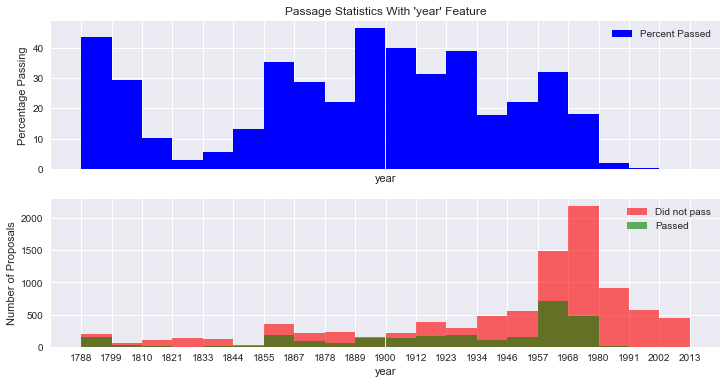

In [28]:
# view passage by year
vs.passage_stats(data, amendment_pass, 'year')

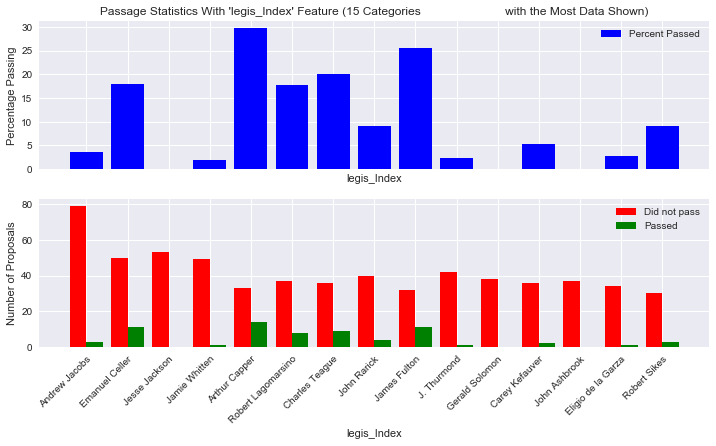

Proposals with missing 'legis_Index' values: 1323 (301 passed, 1022 did not pass)


In [29]:
# view passage by 10 most prolific proposal introducers
vs.passage_stats(data, amendment_pass, 'legis_Index')

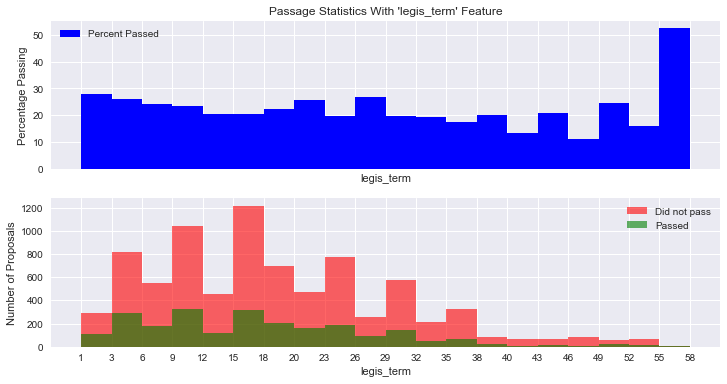

In [30]:
# view passage by term duration of legislator
vs.passage_stats(data, amendment_pass, 'legis_term')

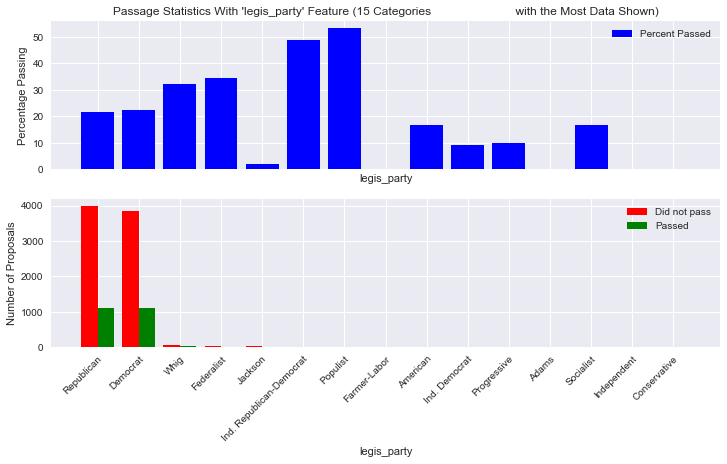

Proposals with missing 'legis_party' values: 1371 (321 passed, 1050 did not pass)


In [31]:
# view passage by legislator party
vs.passage_stats(data, amendment_pass, 'legis_party')

/Users/ydai/Desktop/Udacity/machine-learning-master/capstone/visuals.py:136: RuntimeWarning: invalid value encountered in true_divide
  percent = 100*y_p/(y_np+y_p)


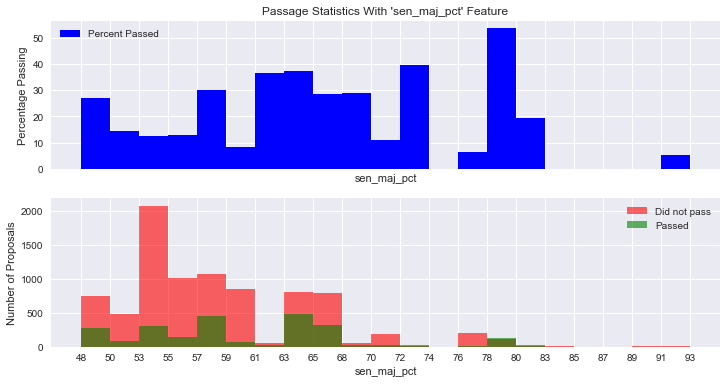

In [32]:
# view passage by legislator party
vs.passage_stats(data, amendment_pass, 'sen_maj_pct')

In [33]:
# pull only ratified amendment data for visualization

# drop failed proposals, 'amendment' = NaN
passed_data = data.dropna(axis=0,subset=['amendment'])
# drop unratified proposals
passed_data = passed_data[passed_data.amendment != 'Unrat']
# convert amendments to ints for correct facetgrid ordering
passed_data['amendment'] = passed_data['amendment'].astype(int)
# drop bill of rights (amendments 1 through 10)
passed_data = passed_data[passed_data.amendment > 10]
# fill NaNs with 'N/A'
passed_data = passed_data.fillna('N/A')


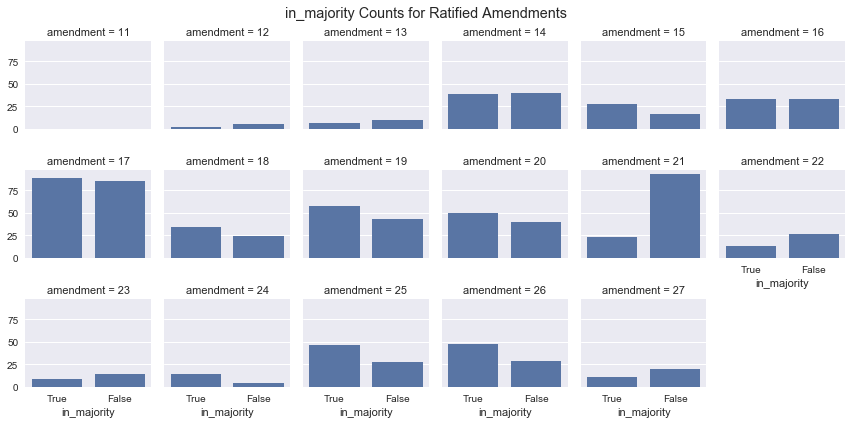

In [34]:
vs.feat_by_amend(passed_data, 'in_majority',[True,False])

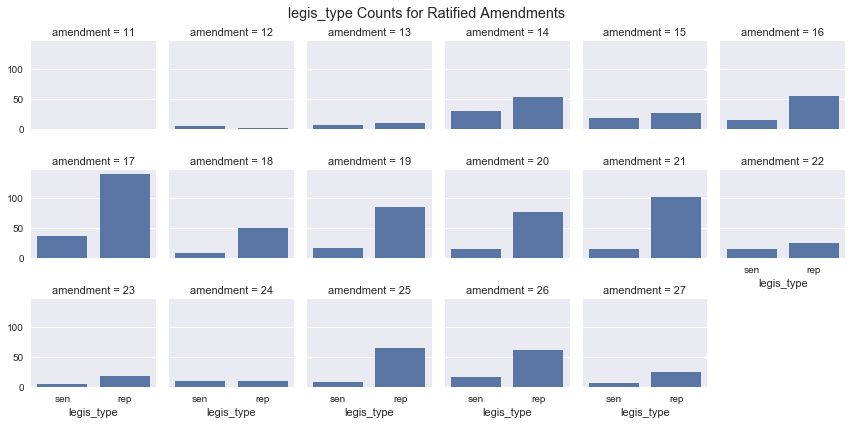

In [35]:
vs.feat_by_amend(passed_data, 'legis_type', ['sen','rep'])

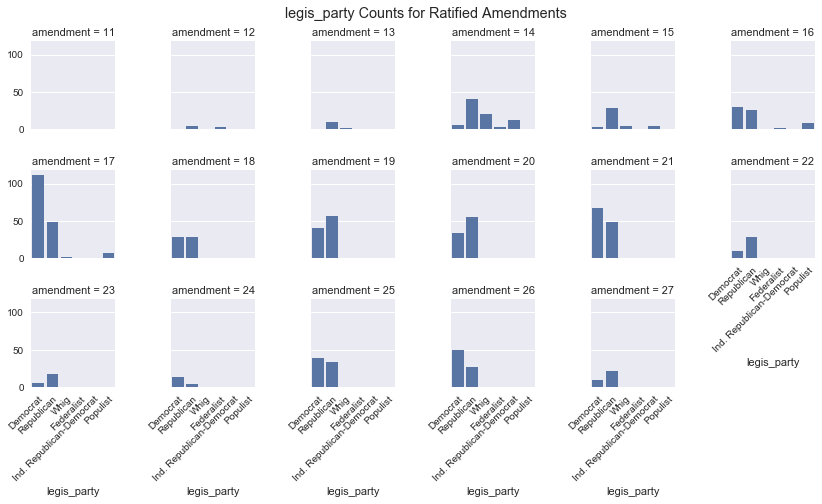

In [36]:
vs.feat_by_amend(passed_data, 'legis_party', ['Democrat','Republican','Whig','Federalist',
                                              'Ind. Republican-Democrat','Populist'])

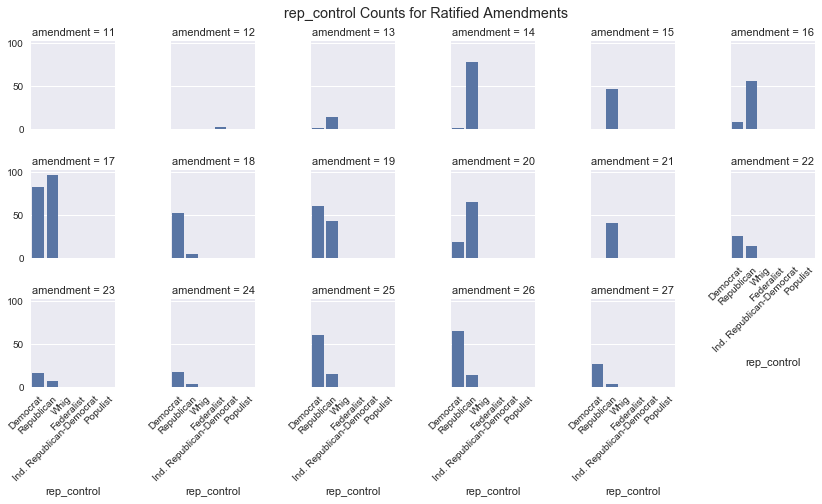

In [37]:
vs.feat_by_amend(passed_data, 'rep_control', ['Democrat','Republican','Whig','Federalist',
                                              'Ind. Republican-Democrat','Populist'])

# Title Text Processing

In [38]:
# apply lowercase and remove 'united states' from titles
lower_titles = data['title'].str.lower()
for i, title in lower_titles.items():
    lower_titles.set_value(i, title.replace('united states',''))
print(lower_titles.tail())

11789    a joint resolution proposing an amendment to t...
11790    a joint resolution proposing a balanced budget...
11791    a joint resolution proposing an amendment to t...
11792    a joint resolution proposing an amendment to t...
11793    a joint resolution proposing an amendment to t...
Name: title, dtype: object


In [39]:
# code reference: https://pythonprogramming.net/tokenizing-words-sentences-nltk-tutorial/
import nltk
from nltk.tokenize import word_tokenize

# split each title into words 
token_titles = lower_titles.apply(word_tokenize)
print(token_titles.head())

0              [reservation, of, nondelegated, powers]
1                 [apportionment, of, representatives]
2    [restriction, on, federal, control, over, elec...
3    [restriction, upon, the, levying, of, direct, ...
4                 [commercial, monopolies, prohibited]
Name: title, dtype: object


In [40]:
from nltk.corpus import stopwords

# remove stopwords from titles
stop_words = set(stopwords.words('english'))

for index, title in token_titles.items():
    token_titles[index] = [w for w in title if not w in stop_words]
print(token_titles.head())

0                  [reservation, nondelegated, powers]
1                     [apportionment, representatives]
2    [restriction, federal, control, election, sena...
3          [restriction, upon, levying, direct, taxes]
4                 [commercial, monopolies, prohibited]
Name: title, dtype: object


In [41]:
# tag parts of speech
pos_titles = pd.Series([])
wnpos_titles = pd.Series([])

for index, title in token_titles.items():
    pos_titles[index] = nltk.pos_tag(title)

    # convert pos labels to lemmatizer usable labels    
    wnpos = []
    for word in pos_titles[index]:
        k = word[1][0].lower()
        wnpos.append((word[0], 'a' if k == 'j' else k if k in ['n', 'r', 'v'] else ''))
    wnpos_titles[index] = wnpos

print(pos_titles.head())
print(wnpos_titles.head())

0    [(reservation, NN), (nondelegated, VBD), (powe...
1        [(apportionment, NN), (representatives, NNS)]
2    [(restriction, NN), (federal, JJ), (control, N...
3    [(restriction, NN), (upon, IN), (levying, VBG)...
4    [(commercial, JJ), (monopolies, NNS), (prohibi...
dtype: object
0    [(reservation, n), (nondelegated, v), (powers,...
1           [(apportionment, n), (representatives, n)]
2    [(restriction, n), (federal, a), (control, n),...
3    [(restriction, n), (upon, ), (levying, v), (di...
4    [(commercial, a), (monopolies, n), (prohibited...
dtype: object


In [42]:
from nltk.stem import WordNetLemmatizer

# lemmatize titles to find stem words
lemmatizer = WordNetLemmatizer()

# pass wn pos tag if available, otherwise use default
lemma_titles = wnpos_titles.apply(lambda x: [lemmatizer.lemmatize(y[0],y[1]) if y[1]!='' else 
                                             lemmatizer.lemmatize(y[0]) for y in x])
print(lemma_titles.head())

0                   [reservation, nondelegated, power]
1                      [apportionment, representative]
2    [restriction, federal, control, election, sena...
3               [restriction, upon, levy, direct, tax]
4                     [commercial, monopoly, prohibit]
dtype: object


In [43]:
pd.set_option('display.max_colwidth', -1)
display(lemma_titles.tail(10))

11784    [joint, resolution, propose, amendment, constitution, relative, equal, right, men, woman, .]                                                                                                                                                                              
11785    [joint, resolution, propose, amendment, constitution, restore, right, american, people, take, away, supreme, court, 's, decision, citizen, united, case, relate, decision, ,, protect, integrity, election, ,, limit, corrosive, influence, money, democratic, process, .]
11786    [joint, resolution, propose, amendment, constitution, limit, power, congress, impose, tax, failure, purchase, good, service, .]                                                                                                                                           
11787    [joint, resolution, propose, amendment, constitution, authorize, congress, prohibit, physical, desecration, flag, .]                                               

In [44]:
# remove generic phrase terms
generic_words = set(['joint', 'resolution', 'propose', 'amendment', 
                  'constitution', 'relate', 'relative', ',', '.', ':'])

clean_titles = pd.Series([])
for index, title in lemma_titles.items():
    clean_titles[index] = [w for w in title if not w in generic_words]
print(clean_titles.tail())

11789    [contribution, expenditure, intend, affect, election]                                                   
11790    [balance, budget]                                                                                       
11791    [apply, law, equally, citizens, federal, government]                                                    
11792    [give, state, right, repeal, federal, law, regulation, ratify, legislatures, two-thirds, several, state]
11793    [parental, right]                                                                                       
dtype: object


In [45]:
# rejoin each title string
clean_titles_join = clean_titles.apply(lambda x: ' '.join(x))

print(clean_titles_join.tail())

11789    contribution expenditure intend affect election                                            
11790    balance budget                                                                             
11791    apply law equally citizens federal government                                              
11792    give state right repeal federal law regulation ratify legislatures two-thirds several state
11793    parental right                                                                             
dtype: object


In [46]:
# save data
pickle.dump((clean_titles, clean_titles_join), open('clean_titles.p', 'wb'))

### Checkpoint: load pickled data when restarting

In [47]:
#load data for new sessions
clean_titles, clean_titles_join = pickle.load(open('clean_titles.p', mode='rb'))

In [48]:
# add clean titles back to main data df
data = data.assign(clean_title = clean_titles_join)
display(data.iloc[1])

amendment                   14                              
title                       Apportionment of Representatives
year                        1788                            
month                       NaN                             
day                         NaN                             
congress                    NaN                             
joint_resolution_chamber    NaN                             
sponsor_name                NaN                             
sponsor_state               NaN                             
committee_of_referral       NaN                             
legis_Index                 NaN                             
legis_district              NaN                             
legis_start                 NaN                             
legis_state                 NaN                             
legis_type                  NaN                             
legis_term                  NaN                             
legis_party             

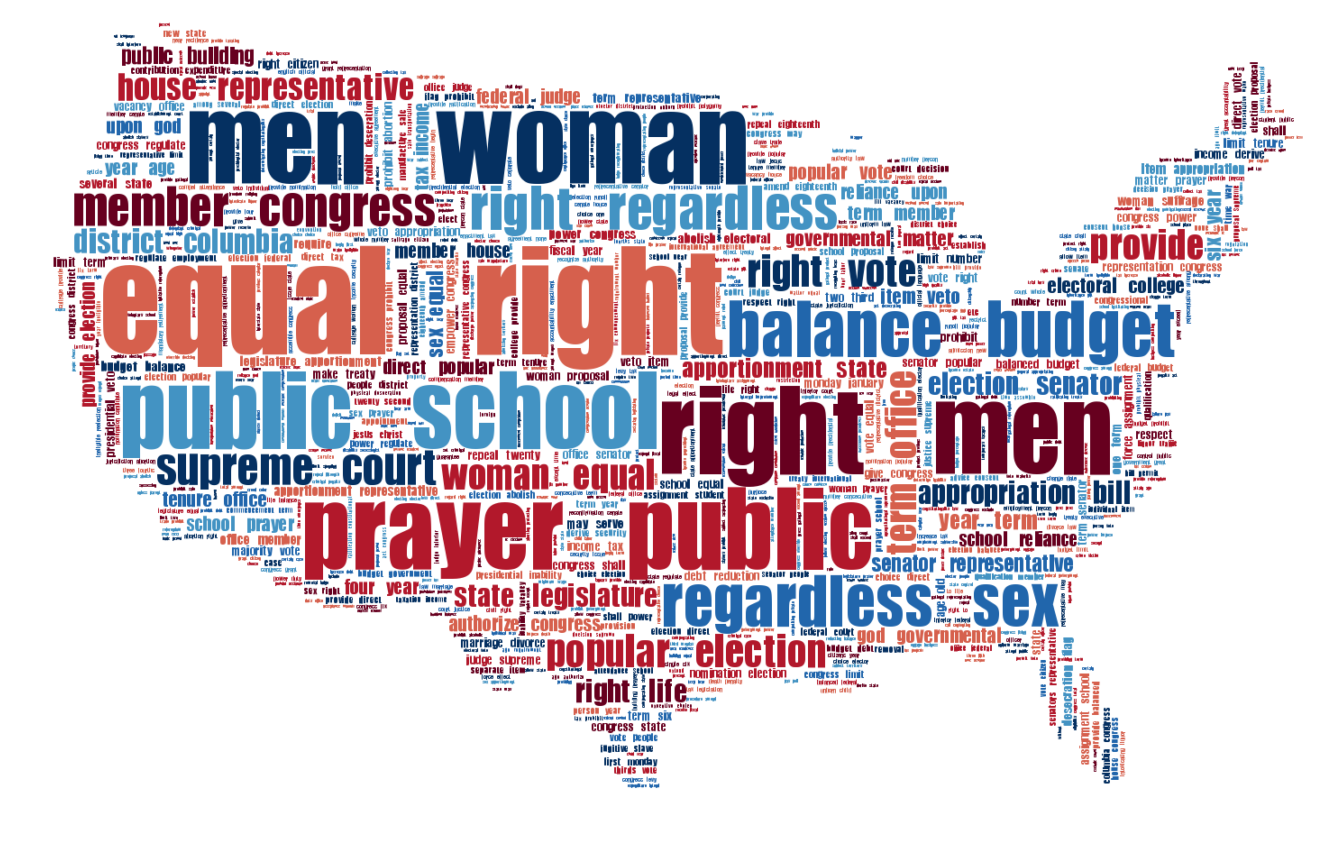

In [49]:
# create a wordcloud
# code reference: https://github.com/minimaxir/stylistic-word-clouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from palettable.colorbrewer.diverging import RdBu_10

# change color palette
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(RdBu_10.colors[random.sample((0,1,2,7,8,9),1)[0]])

# join titles into one continuous string
cont_title = ' '.join(clean_titles_join)

# read mask image of USA
mask = np.array(Image.open('usa.png'))

# generate cloud
font_path = "/Library/Fonts/HeadlineA.ttf"
wc = WordCloud(font_path=font_path, background_color='white', stopwords = set(['president', 'vice']),
               max_words=3000, mask=mask)
wc.generate(cont_title)
wc.recolor(color_func = color_func)
wc.to_file("overall_wordcloud.png")

plt.figure(figsize=(30,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


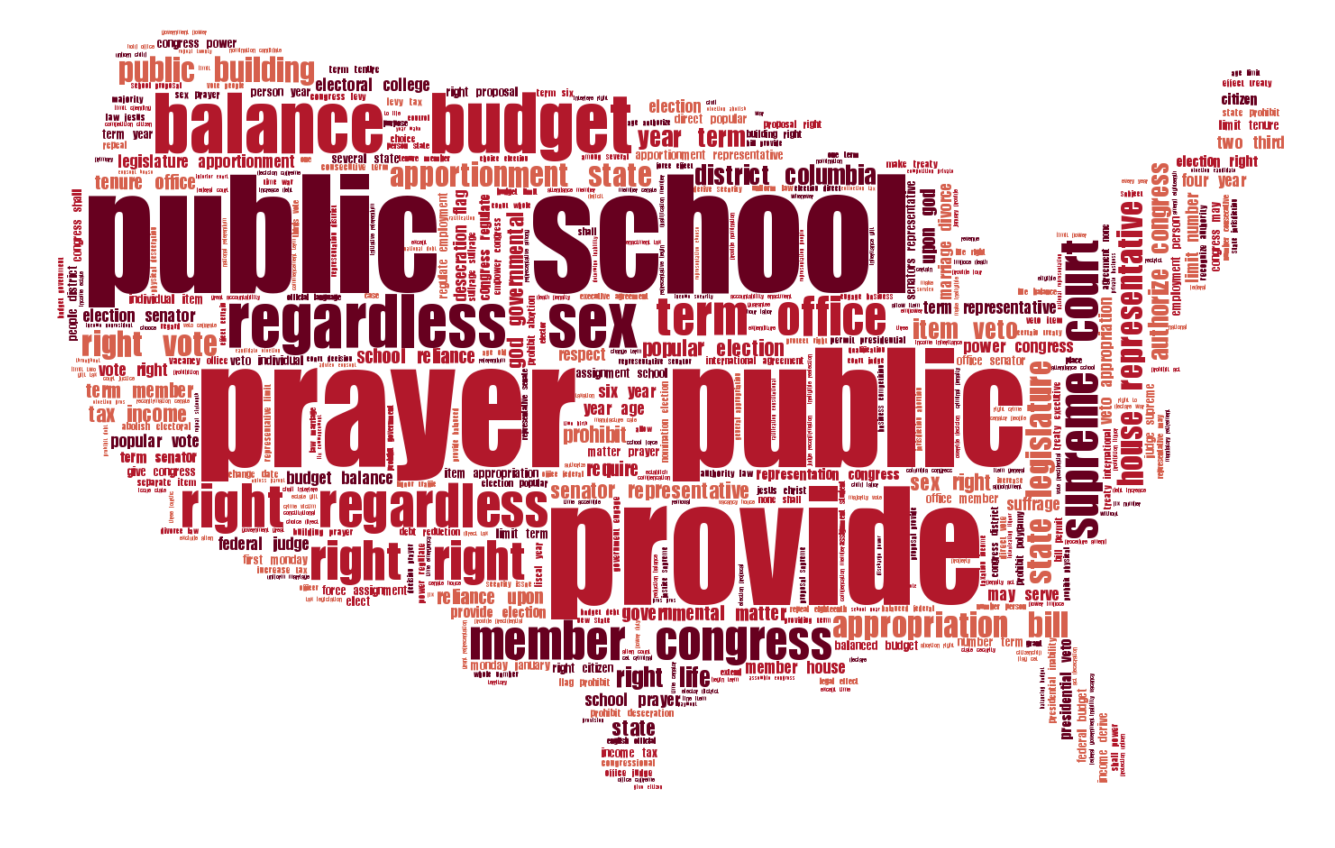

In [50]:
# create a rep wordcloud

# change color palette
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(RdBu_10.colors[random.sample((0,1,2),1)[0]])

# filter for rep
rep_cont_title = ' '.join(data[data['legis_party']=='Republican']['clean_title'])
# join titles into one continuous string
#cont_title = ' '.join(dem_titles_join)

# read mask image of USA
mask = np.array(Image.open('usa.png'))

# generate cloud
font_path = "/Library/Fonts/HeadlineA.ttf"
wc = WordCloud(font_path=font_path, background_color='white', stopwords = set(['president', 'vice', 'equal', 'equal right'
                                                                              'right', 'men', 'woman']),
               max_words=3000, relative_scaling=0, mask=mask, min_font_size=7)
wc.generate(rep_cont_title)
wc.recolor(color_func = color_func)
wc.to_file("rep_wordcloud.png")

plt.figure(figsize=(30,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


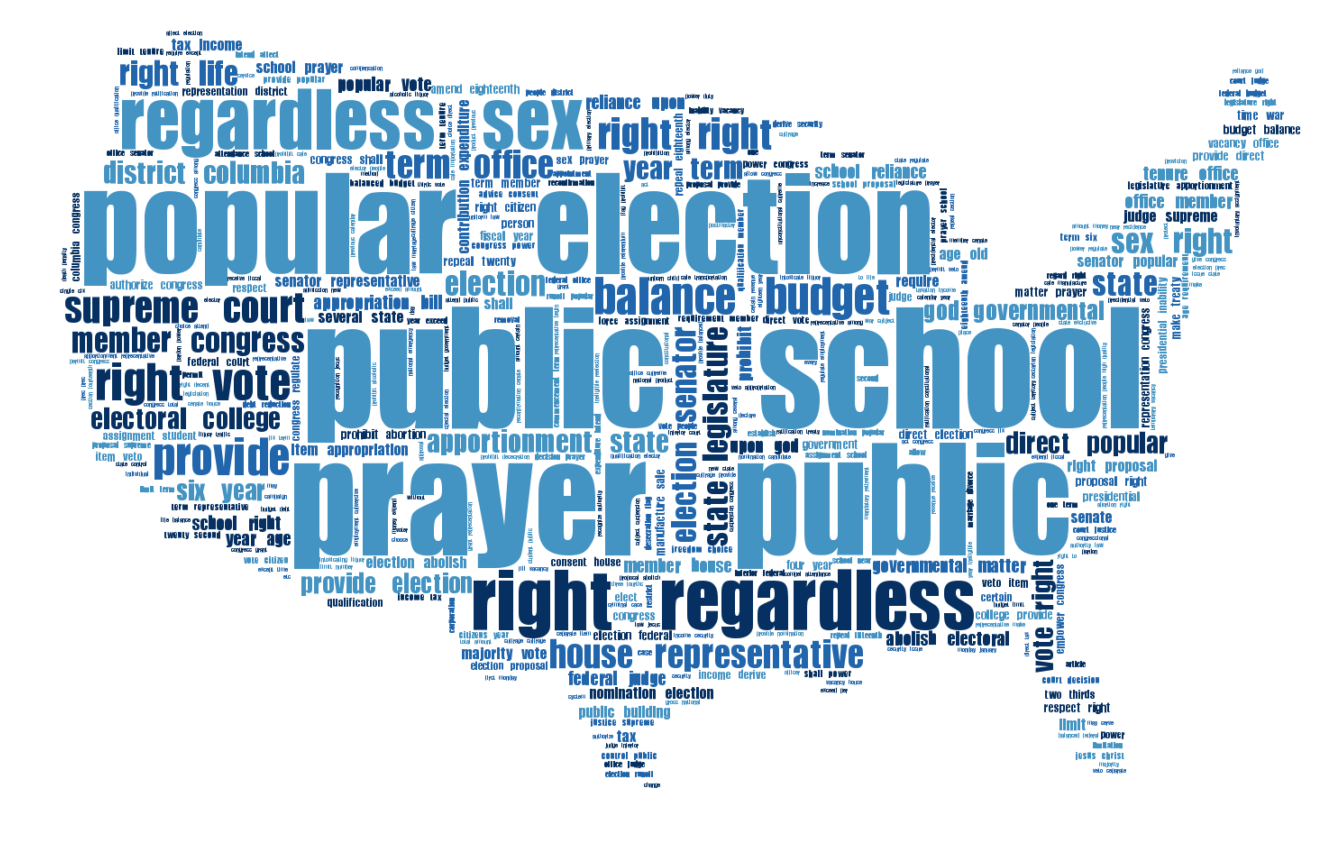

In [51]:
# create a dem wordcloud

# change color palette
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(RdBu_10.colors[random.sample((7,8,9),1)[0]])

# filter for dems
dem_cont_title = ' '.join(data[data['legis_party']=='Democrat']['clean_title'])
# join titles into one continuous string
#cont_title = ' '.join(dem_titles_join)

# read mask image of USA
mask = np.array(Image.open('usa.png'))

# generate cloud
font_path = "/Library/Fonts/HeadlineA.ttf"
wc = WordCloud(font_path=font_path, background_color='white', stopwords = set(['president', 'vice', 'equal', 'equal right'
                                                                              'right', 'men', 'woman']),
               max_words=3000, relative_scaling=0, mask=mask, min_font_size=7)
wc.generate(dem_cont_title)
wc.recolor(color_func = color_func)
wc.to_file("dem_wordcloud.png")

plt.figure(figsize=(30,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [52]:
# prepare title data for topic classifier
# code reference: https://de.dariah.eu/tatom/topic_model_python.html
import sklearn.feature_extraction.text as text
from sklearn import decomposition

vectorizer = text.CountVectorizer(min_df=5)
dtm = vectorizer.fit_transform(data['clean_title']).toarray()
vocab = np.array(vectorizer.get_feature_names())

print(dtm.shape)
print(len(vocab))

(11794, 867)
867


In [53]:
# train classifier to detect topics
num_topics = 500
clf = decomposition.NMF(n_components = num_topics, random_state=1)

# fit title data to topics
doctopic = clf.fit_transform(dtm)
print(clf.components_.shape)

(500, 867)


In [54]:
# normalize each row
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

print(doctopic.shape)

(11794, 500)


/Applications/anaconda/envs/hams/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [55]:
# generate list of topics by pulling the top ranked terms in each topic
topic_words = []

for topic in clf.components_:
    # rank words
    word_idx=np.argsort(topic)[::-1]
    # pull all words with weights > 0.1 (generates a reasonable number of terms)
    topic_words.append([vocab[i] for i in word_idx if topic[i]>0.1])

for t in range(len(topic_words)):
    print('Topic {}: {}'.format(t, ', '.join(topic_words[t])))

Topic 0: president, vice
Topic 1: equal, right
Topic 2: term, department, three, governor
Topic 3: prayer, school
Topic 4: state, sovereign
Topic 5: congress
Topic 6: election
Topic 7: balance, budget, indexing, relates
Topic 8: office, continuance, court
Topic 9: representative
Topic 10: veto, item
Topic 11: office
Topic 12: sex, regardless, equal, right
Topic 13: year, amount, fiscal, exceed, 20, gross, product, receive, suspension, total, expend, revenue, calendar, previous, money, domestic, percent, except, subject, require, time, certain, war, cent
Topic 14: income
Topic 15: monday, first, december, representative, january, cast, term, noon
Topic 16: representative
Topic 17: columbia, district, bring
Topic 18: supreme, court, composition
Topic 19: prohibit, retroactive, compulsory
Topic 20: vote
Topic 21: matter, god, reliance, public, school
Topic 22: senator
Topic 23: federal, electors, town
Topic 24: wealth, conscript, capital, draft, punishment, profiteer
Topic 25: member, hou

In [56]:
#save data
pickle.dump((clf, topic_words, doctopic), open('topic_clf.p', 'wb'))

### Checkpoint: load pickled data when restarting

In [57]:
# load data for new sessions
clf, topic_words, doctopic = pickle.load(open('topic_clf.p', mode='rb'))

In [58]:
for t in range(len(topic_words)):
    print('Topic {}: {}'.format(t, ', '.join(topic_words[t])))

Topic 0: president, vice
Topic 1: equal, right
Topic 2: term, department, three, governor
Topic 3: prayer, school
Topic 4: state, sovereign
Topic 5: congress
Topic 6: election
Topic 7: balance, budget, indexing, relates
Topic 8: office, continuance, court
Topic 9: representative
Topic 10: veto, item
Topic 11: office
Topic 12: sex, regardless, equal, right
Topic 13: year, amount, fiscal, exceed, 20, gross, product, receive, suspension, total, expend, revenue, calendar, previous, money, domestic, percent, except, subject, require, time, certain, war, cent
Topic 14: income
Topic 15: monday, first, december, representative, january, cast, term, noon
Topic 16: representative
Topic 17: columbia, district, bring
Topic 18: supreme, court, composition
Topic 19: prohibit, retroactive, compulsory
Topic 20: vote
Topic 21: matter, god, reliance, public, school
Topic 22: senator
Topic 23: federal, electors, town
Topic 24: wealth, conscript, capital, draft, punishment, profiteer
Topic 25: member, hou

In [59]:
# sanity check
'''
for i in range(10):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    top_topics_pct = ' '.join(str(doctopic[i,t]) for t in top_topics)
    
    print(top_topics_str)
    print(top_topics_pct)
'''

"\nfor i in range(10):\n    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]\n    top_topics_str = ' '.join(str(t) for t in top_topics)\n    top_topics_pct = ' '.join(str(doctopic[i,t]) for t in top_topics)\n    \n    print(top_topics_str)\n    print(top_topics_pct)\n"

In [60]:
# create doctopic df
topic_idx = ['Topic '+str(k) for k in range(len(topic_words))]
topic_df = pd.DataFrame(doctopic, columns=topic_idx)

# see if there are any entries with no topics assigned
print(pd.isnull(topic_df).any(1).nonzero()[0])

# fill NaNs with 0s
topic_df.fillna(0, inplace=True)

# merge topics with data
data_topics = pd.concat([data,topic_df], axis=1)
print(data_topics.shape)

[  235   616   634   822   854  1094  1273  2717  3311  4154 10778 10927
 11065 11135 11137 11182 11595 11639 11748]
(11794, 523)


In [61]:
print(data.shape)
print(data_topics.shape)

(11794, 23)
(11794, 523)


In [62]:
# save data
pickle.dump((data_topics, topic_df), open('data_topics.p', 'wb'))

### Checkpoint: load pickled data when restarting

In [63]:
# load data for new sessions
(data_topics, topic_df) = pickle.load(open('data_topics.p', mode='rb'))

In [81]:
# cluster by topics
# code reference: http://brandonrose.org/clustering
from sklearn.cluster import KMeans

kmt = KMeans(n_clusters = 15)
kmt.fit(topic_df)
topic_clusters = kmt.labels_.tolist()

# merge into main data df
data_topic_cluster = data_topics.assign(cluster=topic_clusters)

Cluster 0 Top 3 Topics:
['congress']
['columbia', 'district', 'bring']
['office']

Cluster 1 Top 3 Topics:
['vote', 'right', 'extends', 'african']
['vote']
['right', 'conscience', 'home', 'reproductive', 'extension', 'work', 'preserve', 'proceeding', 'victim', 'interference', 'pray', 'opportunity', 'alter', 'local', 'eighteen', 'trial', 'corporate', 'assemble', 'support', 'meet', 'recognition', 'militia', 'defendant', 'lawful', 'devolves', 'guaranteed']

Cluster 2 Top 3 Topics:
['public']
['prayer', 'building', 'public', 'offer']
['school', 'near', 'neighborhood', 'construe', 'assistance', 'common']

Cluster 3 Top 3 Topics:
['qualification', 'electors']
['congress']
['office']

Cluster 4 Top 3 Topics:
['balance', 'budget', 'indexing', 'relates']
['full', 'balance', 'growth']
['budget', 'percentage', 'gnp', 'receive', 'large', 'outside', 'alter', 'outlay', 'annual']

Cluster 5 Top 3 Topics:
['sex', 'regardless', 'equal', 'right']
['equal', 'right']
['right', 'conscience', 'home', 'repro

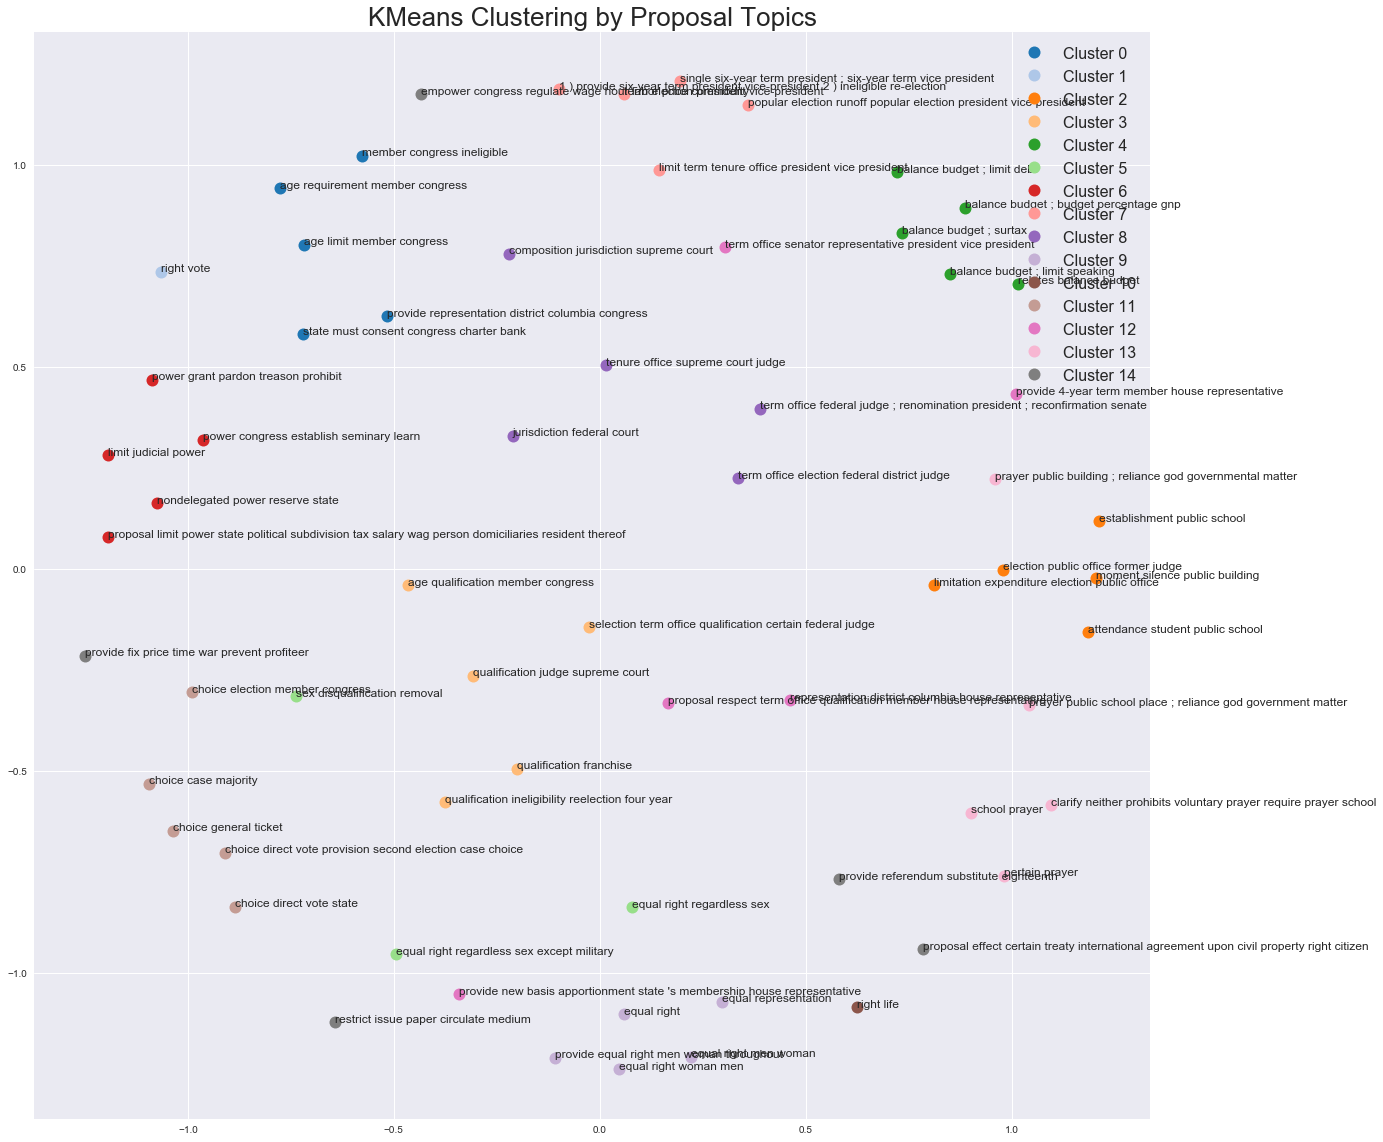

In [83]:
# print top terms per cluster
order_centroids_t = kmt.cluster_centers_.argsort()[:,::-1]

for i in range(len(order_centroids_t)):
    print('Cluster %d Top 3 Topics:' %i)
    for ind in order_centroids_t[i, :3]: 
        print(topic_words[ind])
    print()

# plot topic clusters
vs.cluster_plot(data_topic_cluster, 'Topics')

# Prepare Features for Classifier Training

In [66]:
# view all fields
#print(data_cluster.iloc[-1])

# reduce dataset to useful features for training
# drop: amendment (label), title (use topics instead), sponsor_name, legis_Index,
#       legis_state (duplicate of sponsor_state)
data_train = data_topics.drop(['amendment', 'title', 'sponsor_name', 'legis_Index', 
                                'legis_state', 'clean_title'], axis=1)

# view features for training
#print(data_train.iloc[-1])

In [67]:
# convert categorical variables into dummy variables
data_dummies = pd.get_dummies(data_train)

# fill NaNs with 0s
data_dummies.fillna(0.0, inplace=True)

# view result
print(data_dummies.iloc[-1])

year                                  2014.0
month                                 6.0   
day                                   4.0   
congress                              113.0 
legis_district                        3.0   
legis_start                           1995.0
legis_term                            26.0  
sen_maj_pct                           53.0  
rep_maj_pct                           53.8  
Topic 0                               0.0   
Topic 1                               0.0   
Topic 2                               0.0   
Topic 3                               0.0   
Topic 4                               0.0   
Topic 5                               0.0   
Topic 6                               0.0   
Topic 7                               0.0   
Topic 8                               0.0   
Topic 9                               0.0   
Topic 10                              0.0   
Topic 11                              0.0   
Topic 12                              0.0   
Topic 13  

In [68]:
#save data
pickle.dump((data_dummies, amendment_pass), open('data_dummies.p', 'wb'))

### Checkpoint: load pickled data when restarting

In [69]:
# load data for new sessions
(data_dummies, amendment_pass) = pickle.load(open('data_dummies.p', mode='rb'))

# K-Means Cluster with All Features

Cluster 0 Top 3 Features:
year
legis_start
congress

Cluster 1 Top 3 Features:
year
day
Topic 49

Cluster 2 Top 3 Features:
year
legis_start
sen_maj_pct

Cluster 3 Top 3 Features:
year
congress
rep_maj_pct

Cluster 4 Top 3 Features:
rep_maj_pct
sen_maj_pct
congress

Cluster 5 Top 3 Features:
year
legis_start
sen_maj_pct

Cluster 6 Top 3 Features:
year
legis_start
congress

Cluster 7 Top 3 Features:
year
day
month

Cluster 8 Top 3 Features:
legis_start
congress
rep_maj_pct

Cluster 9 Top 3 Features:
year
legis_start
congress

Cluster 10 Top 3 Features:
year
legis_start
congress

Cluster 11 Top 3 Features:
year
legis_start
day

Cluster 12 Top 3 Features:
year
legis_start
congress

Cluster 13 Top 3 Features:
year
legis_start
congress

Cluster 14 Top 3 Features:
year
rep_maj_pct
sen_maj_pct



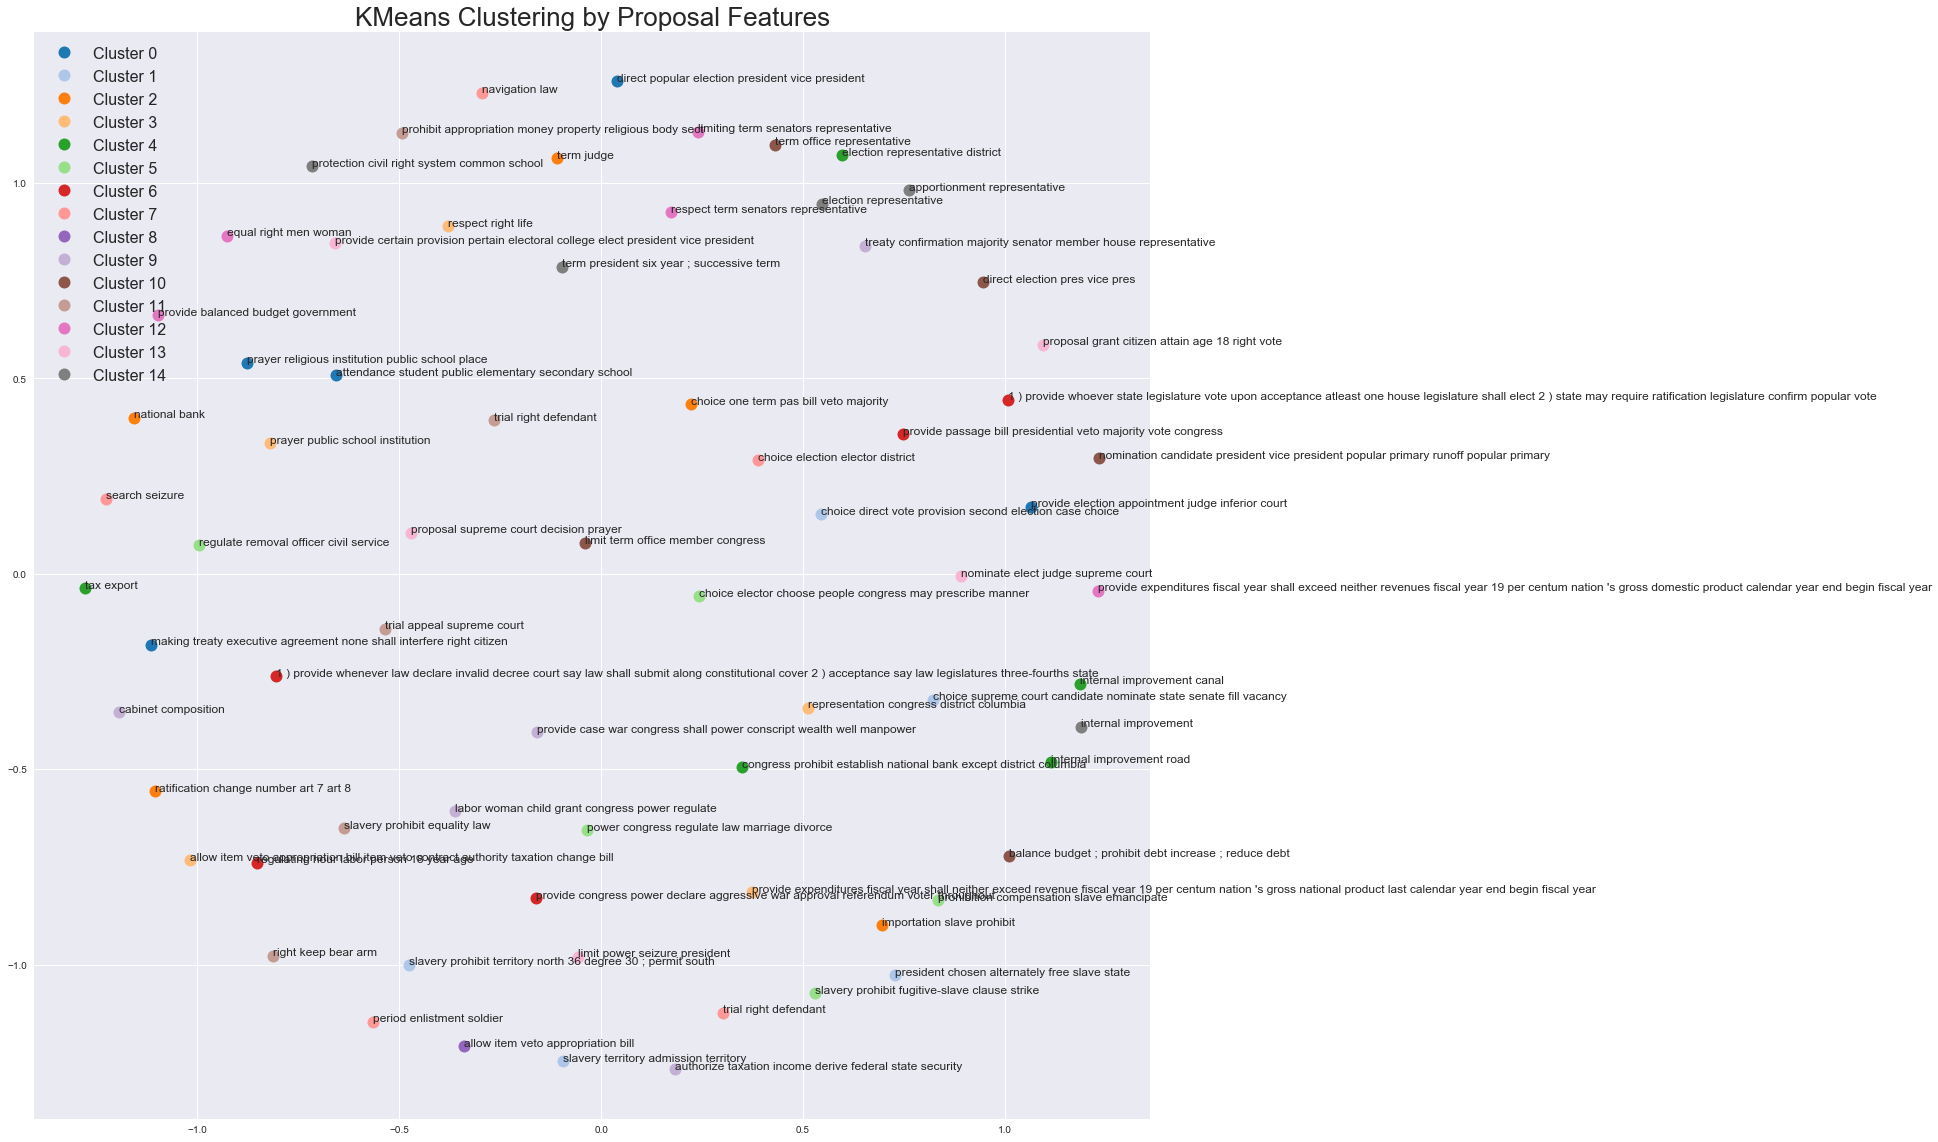

In [84]:
# cluster by feature
# code reference: http://brandonrose.org/clustering
from sklearn.cluster import KMeans

kmf = KMeans(n_clusters = 15)
kmf.fit(data_dummies)
feat_clusters = kmf.labels_.tolist()

# merge into main data df
data_feat_cluster = data_dummies.assign(clean_title = clean_titles_join, cluster=feat_clusters)

# print top features per cluster
order_centroids_f = kmf.cluster_centers_.argsort()[:,::-1]

for i in range(len(order_centroids_f)):
    print('Cluster %d Top 3 Features:' %i)
    for ind in order_centroids_f[i, :3]: 
        print(list(data_dummies)[ind])
    print()

vs.cluster_plot(data_feat_cluster, 'Features')

# Supervised Learning Passage Classifier

In [71]:
#features: data_dummies
#labels: amendment_pass

#split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_dummies, amendment_pass, test_size = 0.2,
                                                   random_state = 0)

#check split
print('Training set has {} samples.'.format(X_train.shape[0]))
print('Test set has {} samples.'.format(X_test.shape[0]))

Training set has 9435 samples.
Test set has 2359 samples.


In [72]:
# naive predictor
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

nproposals = len(amendment_pass)

# generate naive random output with a 22.4% passage rate to match 
#    the true number of positives
naivepred = np.random.choice([0,1],size=nproposals,p=[.776,.224])

# calculate accuracy
accuracy = accuracy_score(amendment_pass, naivepred)

# calculate fscore
fscore = fbeta_score(amendment_pass, naivepred, beta=0.5)

# print results
print('Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]'.format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.6488, F-score: 0.2169]


In [73]:
# train/predict function to take data and learner and output results
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # calculate the training time
    results['train_time'] = end - start
        
    # get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # calculate the total prediction time
    results['pred_time'] = end - start
            
    # compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # return the results
    return results

GaussianNB trained on 94 samples.
GaussianNB trained on 943 samples.
GaussianNB trained on 9435 samples.
RandomForestClassifier trained on 94 samples.
RandomForestClassifier trained on 943 samples.
RandomForestClassifier trained on 9435 samples.


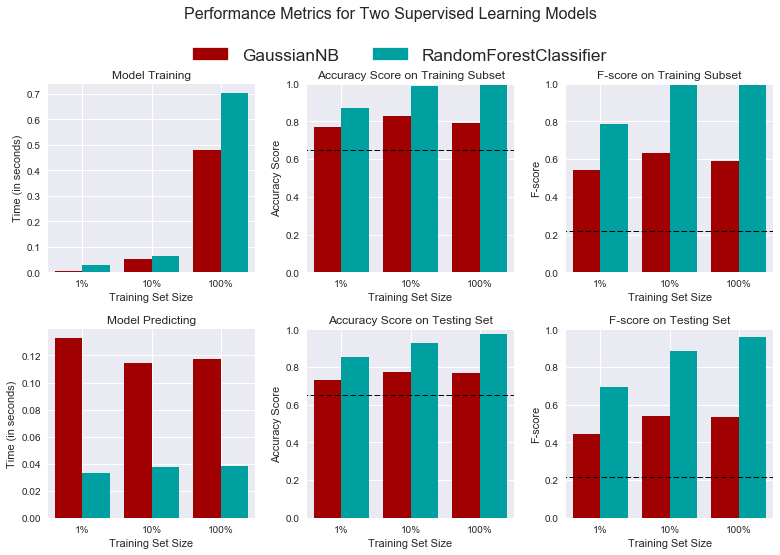

In [74]:
# import supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# initialize models
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state=42)

# calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train)/100)
samples_10 = int(len(X_train)/10)
samples_100 = len(X_train)

# collect results on the learners
results = {}
for clf in [clf_A, clf_B]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [75]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import make_scorer

# initialize the classifier
clf = RandomForestClassifier(random_state=42)

# create the parameters list you wish to tune
parameters = {'n_estimators':[5,10,50], 
              'criterion':['gini','entropy'],
              'min_samples_split':[2,5,10],
              'min_samples_leaf':[1,2,5]}

# make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# split lables evenly between validation sets
sss = StratifiedShuffleSplit(n_splits=3, random_state=42)
cv = sss.split(np.zeros(len(y_train)),y_train)

# perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scorer, cv=cv)

# fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# get the estimator
best_clf = grid_fit.best_estimator_

# make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [76]:
# Report the before-and-afterscores
print('Unoptimized model\n------')
print('Accuracy score on testing data: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('F-score on testing data: {:.4f}'.format(fbeta_score(y_test, predictions, beta = 0.5)))
print('\nOptimized Model\n------')
print('Final accuracy score on the testing data: {:.4f}'.format(accuracy_score(y_test, best_predictions)))
print('Final F-score on the testing data: {:.4f}'.format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.9750
F-score on testing data: 0.9594

Optimized Model
------
Final accuracy score on the testing data: 0.9792
Final F-score on the testing data: 0.9664


In [77]:
# to see what the optimized model parameters were
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)


In [78]:
# Extract the feature importances
importances = best_clf.feature_importances_

# drop the topic features
nt_importances = importances[pd.np.r_[0:9, 509:671]]
topic_idx = ['Topic '+str(k) for k in range(500)]
nt_X_train = X_train.drop(topic_idx,axis=1)

# check shape of data
print(nt_X_train.shape)

(9435, 171)


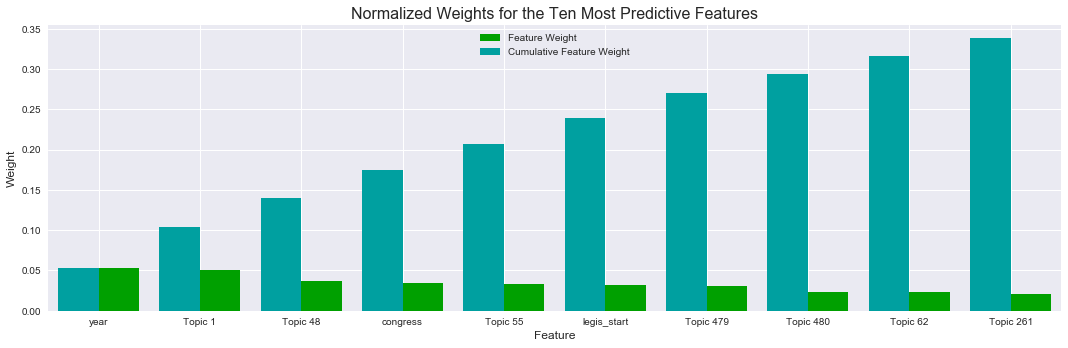

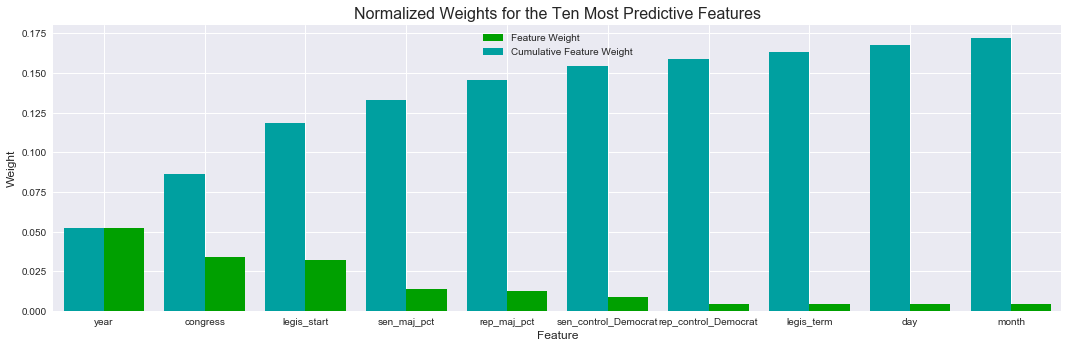

In [79]:
# Plot overall most important features
vs.feature_plot(importances, X_train, y_train)

# Plot most important features excluding topics
vs.feature_plot(nt_importances, nt_X_train, y_train)